# Bridge Matching

## Import

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
from BM import MLP, SDE_Solver, train_velocity_forward, sample_2d_gaussian, sample_2d_swiss_roll
%matplotlib inline

## Global Params

In [2]:
#======
#Device params
DEVICE = "cuda"
#SEED = 2024
#torch.manual_seed(SEED); np.random.seed(SEED)

#=====
#Data params
STD = 0.5 #Swiss Roll std (manages the "tightness")
DATA_N = 5000 #number of points 

#=====
#Neural network params
LAYER_LIST = [3, 256, 512, 1024, 512, 256, 2]
L_R = 1e-3
EPOCHES = 20000
BATCH_SIZE = 64

#======
#SDE params
EPS = 0 #Epsilon or variance for SDE
STEPS = 1000 #Steps for time discretization in Euler-Maruyama method

## Data

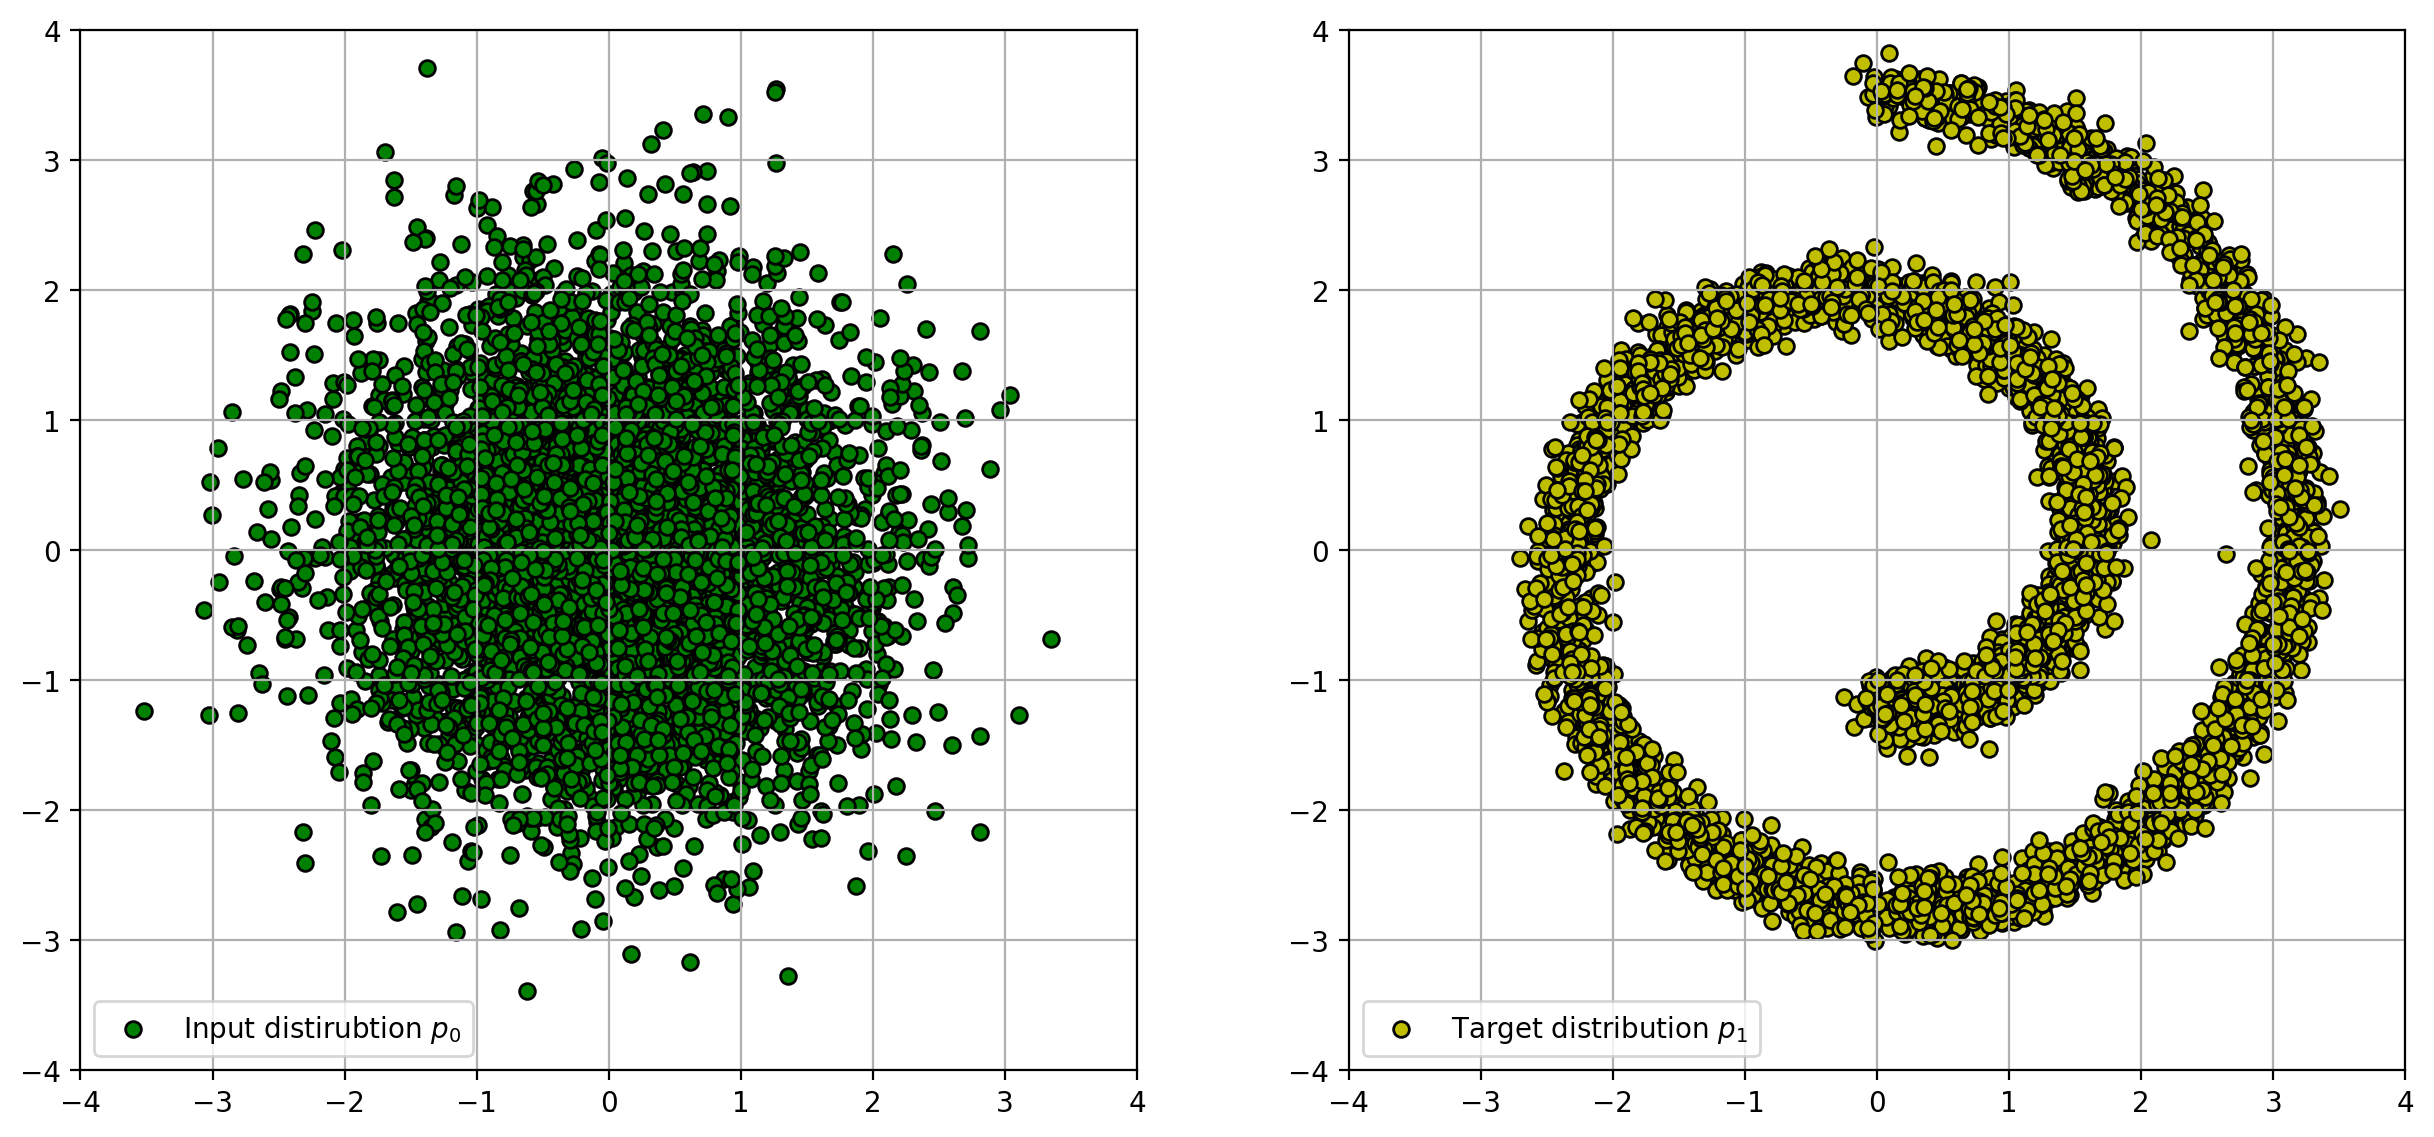

In [3]:
X = sample_2d_gaussian(batch_size=DATA_N)
Y = sample_2d_swiss_roll(batch_size=DATA_N, scaler=0.25, std=STD)

fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

axes[0].scatter(X[:, 0], X[:, 1], alpha=1, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[1].scatter(Y[:, 0], Y[:, 1], 
                c="y", s=32, edgecolors="black", label = r"Target distribution $p_1$")

for ax in axes:
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.legend(loc="lower left")

## Velocity/Drift model Training

$V_{\theta}(x,t): \mathbb{R}^{n+1} \to \mathbb{R}^{n}$ - velocity or drift, since we sample an object with two coordinates $(x, y)$, hence $\mathbb{n = 2}$

In [4]:
#=====
#Define a network
velocity_net = MLP(layer_list=LAYER_LIST)
velocity_net.reset_parameters()

Vnet params: 1314562


In [5]:
#=====
#Train a network
loss_value = train_velocity_forward(velocity_net, batch_size=BATCH_SIZE,epoches=EPOCHES, eps=EPS, std=STD, l_r=L_R, device=DEVICE)

100%|██████████| 20000/20000 [00:32<00:00, 615.12it/s]


## SDE Solver

In [6]:
solver = SDE_Solver(vnet=velocity_net,steps=STEPS, eps=EPS, device=DEVICE)

## Plot Results

In [7]:
"""import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

x_samples = sample_2d_gaussian(DATA_N)
y_samples = sample_2d_swiss_roll(DATA_N, std=STD)
trajectory, y_pred = solver.solve(x_samples)

tr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])
tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1
trajectory_example, pred_example = solver.solve(tr_samples)


axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")



for ax in axes[1:]:

    ax.scatter(y_pred[:, 0], y_pred[:, 1], 
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)




    ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

    ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1], 
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

    for i in range(12):
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
        if i == 0:
            ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
        else:
            ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.legend(loc="lower left")

fig.tight_layout(pad=0.1)
"""


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11913/948816751.py:1: SyntaxWarning: invalid escape sequence '\s'
  """import matplotlib.pyplot as plt


'import matplotlib.pyplot as plt\n\nfig, axes = plt.subplots(1, 4, figsize=(15, 6.75), dpi=200)\n\nfor ax in axes:\n    ax.grid(zorder=-20)\n\nx_samples = sample_2d_gaussian(DATA_N)\ny_samples = sample_2d_swiss_roll(DATA_N, std=STD)\ntrajectory, y_pred = solver.solve(x_samples)\n\ntr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])\ntr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1\ntrajectory_example, pred_example = solver.solve(tr_samples)\n\n\naxes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, \n                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")\naxes[0].scatter(y_samples[:, 0], y_samples[:, 1], \n                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")\n\n\n\nfor ax in axes[1:]:\n\n    ax.scatter(y_pred[:, 0], y_pred[:, 1], \n           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)\n\n\n\n\n    ax.scatter(tr_samples[

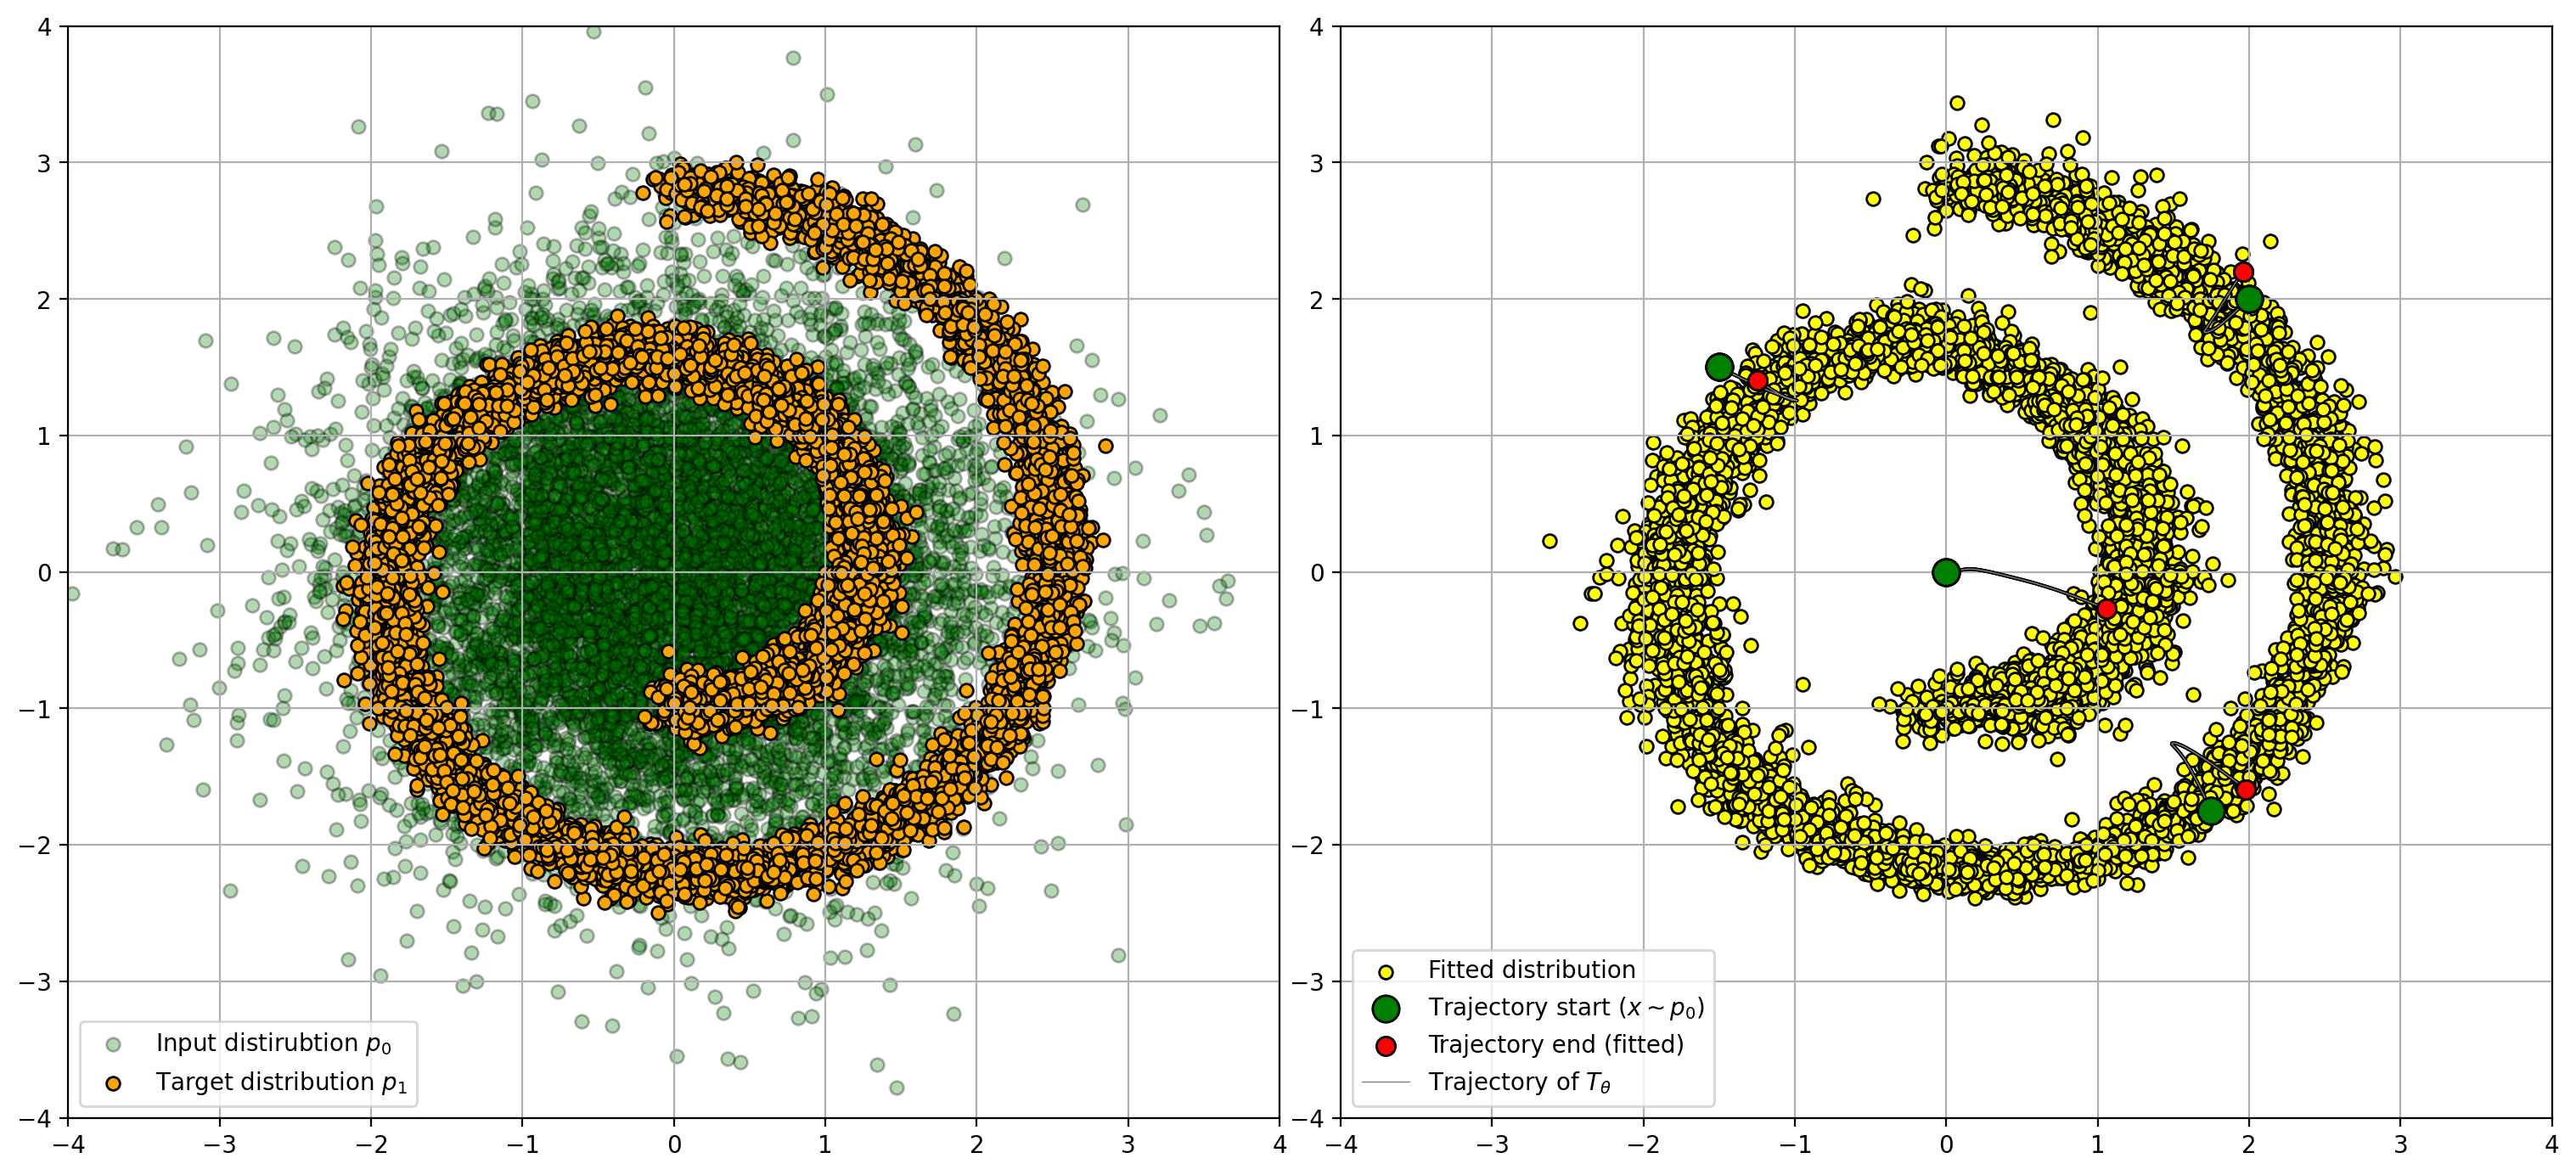

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

x_samples = sample_2d_gaussian(10000)
y_samples = sample_2d_swiss_roll(10000, std=STD)
trajectory, y_pred = solver.solve(x_samples)

tr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])

tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")

ax.scatter(y_pred[:, 0], y_pred[:, 1], 
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)

trajectory_example, pred_example = solver.solve(tr_samples)

#print(pred_example)

ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1], 
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

for i in range(12):
    ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
    if i == 0:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
    else:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.legend(loc="lower left")

fig.tight_layout(pad=0.1)
